In [5]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson

In [6]:
stress_df = pd.read_csv('/home/s232713/data/gps_trip_stress_single1.csv')
env_df = pd.read_csv('/home/s232713/data/foot_time_env.csv')

display(stress_df.head())
display(env_df.head())

print(stress_df['participant ID'].unique())


,participant ID,INDIVID,Timestamp,Latitude,Longitude,Accuracy,Altitude,Speed,Interval ID,Activity_concat,Milliseconds,stress_label,stress_prob,stress_binary
0,103,MMM16101,2024-01-11 17:51:03,55.687274,12.491865,5.536,51.503750,0.851257,360335,Foot,1704995463000,2.0,0.391363,0
1,103,MMM16101,2024-01-11 17:51:03,55.687275,12.491863,5.518,50.813382,0.825126,360335,Foot,1704995463000,2.0,0.391363,0
2,103,MMM16101,2024-01-11 17:51:04,55.687275,12.491866,5.473,50.801331,0.815093,360335,Foot,1704995464000,2.0,0.391363,0
3,103,MMM16101,2024-01-11 17:51:04,55.687278,12.491853,5.420,52.414494,0.809921,360335,Foot,1704995464000,2.0,0.391363,0
4,103,MMM16101,2024-01-11 17:51:05,55.687279,12.491853,5.367,52.414494,0.785326,360335,Foot,1704995465000,1.0,0.500000,1


,INDIVID,Interval ID,GRID_ID,t_entry,t_exit,type,Start Time_x,stress,start_dt,year,...,Wall,Utility Pole,Sky,Pole,Bicyclist,Bus,Lane Marking - General,Other Rider,Curb,Bicycle
0,MMM12501,265109,190047,2023-11-08 13:54:08,2023-11-08 13:55:34,line_cross,2023-11-08 13:53:57,1,2023-11-08 13:53:57,2023,...,0.303040,0.032120,45.786037,0.131664,0.000000,0.007706,1.840706,0.000000,1.308880,0.027180
1,MMM12501,265109,190703,2023-11-08 13:55:34,2023-11-08 13:56:37,line_cross,2023-11-08 13:53:57,1,2023-11-08 13:53:57,2023,...,0.186329,0.008888,45.511530,0.134697,0.000000,0.034084,0.584087,0.000000,1.017246,0.000000
2,MMM12501,265109,190704,2023-11-08 13:53:57,2023-11-08 13:54:08,line_cross,2023-11-08 13:53:57,1,2023-11-08 13:53:57,2023,...,0.078812,0.029297,45.058765,0.178432,0.000134,0.000000,0.967426,0.000000,0.170422,0.017872
3,MMM12501,265109,191360,2023-11-08 13:56:37,2023-11-08 13:56:37,buffer_only,2023-11-08 13:53:57,1,2023-11-08 13:53:57,2023,...,1.113256,0.002041,35.056755,0.093575,0.000000,0.000000,0.000305,0.000000,0.768579,0.000000
4,MMM12501,266118,187406,2023-11-09 11:34:35,2023-11-09 11:34:36,line_cross,2023-11-09 11:28:42,0,2023-11-09 11:28:42,2023,...,3.148632,0.001736,36.127605,0.046902,0.802364,0.000000,0.446949,0.033226,1.607914,0.262966


[103]


In [7]:
env_df.columns.values

array(['INDIVID', 'Interval ID', 'GRID_ID', 't_entry', 't_exit', 'type',
       'Start Time_x', 'stress', 'start_dt', 'year', 'month', 'day',
       'date', 'is_day', 'grid_ndvi_min', 'grid_ndvi_max',
       'grid_ndvi_mean', 'grid_ndvi_std', 'mean_temp', 'acc_precip',
       'bright_sunshine', 'mean_wind_speed', 'mean_relative_hum',
       'mean_pressure', 'mean_cloud_cover', 'day_L_mean', 'day_L_std',
       'day_L_min', 'day_L_max', 'day_share_quiet_', 'day_share_45_50',
       'day_share_50_55', 'day_share_55_60', 'day_share_60_65',
       'day_share_65_70', 'day_share_70_75', 'day_share_75_80',
       'day_is_censored', 'night_L_mean', 'night_L_std', 'night_L_min',
       'night_L_max', 'night_share_quiet_', 'night_share_45_50',
       'night_share_50_55', 'night_share_55_60', 'night_share_60_65',
       'night_share_65_70', 'night_share_70_75', 'night_share_75_80',
       'night_is_censored', 'noise_L_mean', 'noise_L_min', 'noise_L_max',
       'noise_L_std', 'noise_share_quiet_'

In [8]:
stress_df["Timestamp"] = pd.to_datetime(stress_df["Timestamp"])

interval_durations = (
    stress_df
    .groupby(["participant ID", "Interval ID"])["Timestamp"]
    .agg(lambda x: (x.max() - x.min()).total_seconds())
    .reset_index(name="interval_seconds")
)

total_seconds_per_participant = (
    interval_durations
    .groupby("participant ID")["interval_seconds"]
    .sum()
    .reset_index(name="total_seconds")
)

total_seconds_per_participant["total_minutes"] = (
    total_seconds_per_participant["total_seconds"] / 60
)

print(total_seconds_per_participant)

   participant ID  total_seconds  total_minutes
0             103        33809.0     563.483333


In [9]:
participant = 103
INDIVID = stress_df.loc[stress_df['participant ID'] == participant, 'INDIVID'].values[0]
print(f"Analyzing data for participant ID: {participant}, INDIVID: {INDIVID}")

stress_sub = stress_df.loc[
    stress_df["INDIVID"] == INDIVID,
    [
        "INDIVID",
        "Timestamp",
        "Interval ID",
        "stress_prob",
    ]
].copy()

stress_sub["Timestamp"] = pd.to_datetime(stress_sub["Timestamp"])
stress_sub = stress_sub.sort_values("Timestamp")
# print(stress_sub.columns.values)

Analyzing data for participant ID: 103, INDIVID: MMM16101


In [10]:
# pruned some env variables
env_cols = [
    "INDIVID",
    "Interval ID",
    "grid_ndvi_mean",
    "noise_L_mean",
    "roads_transportation",
    "buildings_facilities"
]

env_sub = env_df.loc[
    env_df["INDIVID"] == INDIVID,
    env_cols
].copy()
# print(env_sub.columns.values)


In [11]:
df = stress_sub.merge(
    env_sub,
    on=["INDIVID", "Interval ID"],
    how="left"
)

df = df.sort_values("Timestamp")

display(df.head())
print(df.shape)
print(df.info())

,INDIVID,Timestamp,Interval ID,stress_prob,grid_ndvi_mean,noise_L_mean,roads_transportation,buildings_facilities
0,MMM16101,2024-01-11 17:51:03,360335,0.391363,0.057879,54.270435,5.0,2.0
19,MMM16101,2024-01-11 17:51:03,360335,0.391363,0.035143,53.775944,5.0,5.0
20,MMM16101,2024-01-11 17:51:03,360335,0.391363,0.111105,49.993540,9.0,6.0
21,MMM16101,2024-01-11 17:51:03,360335,0.391363,0.010313,53.775944,4.0,3.0
22,MMM16101,2024-01-11 17:51:03,360335,0.391363,-0.008584,54.270435,5.0,2.0


(594069, 8)
<class 'pandas.core.frame.DataFrame'>
Index: 594069 entries, 0 to 594068
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   INDIVID               594069 non-null  object        
 1   Timestamp             594069 non-null  datetime64[ns]
 2   Interval ID           594069 non-null  int64         
 3   stress_prob           542369 non-null  float64       
 4   grid_ndvi_mean        589614 non-null  float64       
 5   noise_L_mean          589614 non-null  float64       
 6   roads_transportation  589614 non-null  float64       
 7   buildings_facilities  589614 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 40.8+ MB
None


In [12]:
df["stress_lag1"] = (
    df.groupby("Interval ID")["stress_prob"]
      .shift(1)
)

df["stress_lag2"] = (
    df.groupby("Interval ID")["stress_prob"]
      .shift(2)
)

display(df.head())
print(df['stress_lag1'].value_counts())
print(df['stress_lag2'].value_counts())

,INDIVID,Timestamp,Interval ID,stress_prob,grid_ndvi_mean,noise_L_mean,roads_transportation,buildings_facilities,stress_lag1,stress_lag2
0,MMM16101,2024-01-11 17:51:03,360335,0.391363,0.057879,54.270435,5.0,2.0,NaN,NaN
19,MMM16101,2024-01-11 17:51:03,360335,0.391363,0.035143,53.775944,5.0,5.0,0.391363,NaN
20,MMM16101,2024-01-11 17:51:03,360335,0.391363,0.111105,49.993540,9.0,6.0,0.391363,0.391363
21,MMM16101,2024-01-11 17:51:03,360335,0.391363,0.010313,53.775944,4.0,3.0,0.391363,0.391363
22,MMM16101,2024-01-11 17:51:03,360335,0.391363,-0.008584,54.270435,5.0,2.0,0.391363,0.391363


stress_lag1
0.500000    489129
0.344438       228
0.342988       152
0.351216       152
0.346838       152
             ...  
0.345042         1
0.343095         1
0.343706         1
0.346201         1
0.343917         1
Name: count, Length: 1745, dtype: int64
stress_lag2
0.500000    489091
0.344438       228
0.342988       152
0.351216       152
0.346838       152
             ...  
0.345042         1
0.343095         1
0.343706         1
0.346201         1
0.343917         1
Name: count, Length: 1745, dtype: int64


In [13]:
model_cols = [
    "stress_prob",
    "stress_lag1",
    "stress_lag2",
    "grid_ndvi_mean",
    "noise_L_mean",
    "roads_transportation",
    "buildings_facilities",
]

df_model = df[model_cols].dropna()

y = df_model["stress_prob"]
X = df_model.drop(columns=["stress_prob"])

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print('High frequency model results:', model.summary())


High frequency model results:                             OLS Regression Results                            
Dep. Variable:            stress_prob   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                 1.320e+06
Date:                Mon, 19 Jan 2026   Prob (F-statistic):               0.00
Time:                        15:00:07   Log-Likelihood:             1.7020e+06
No. Observations:              537858   AIC:                        -3.404e+06
Df Residuals:                  537851   BIC:                        -3.404e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
co

----------
# 10s bins aggregation 

In [14]:
BIN_SEC = 10

stress_sub = stress_df.loc[
    stress_df["INDIVID"] == INDIVID,
    ["Timestamp", "stress_prob"]
].copy()

stress_sub["Timestamp"] = pd.to_datetime(stress_sub["Timestamp"])
stress_sub = stress_sub.sort_values("Timestamp")

env_cols = [
    "INDIVID",
    "GRID_ID",
    "t_entry",
    "t_exit",
    "grid_ndvi_mean",
    "noise_L_mean",
    "roads_transportation",
    "buildings_facilities"
]

env_sub = env_df.loc[
    env_df["INDIVID"] == INDIVID,
    env_cols
].copy()

env_sub["t_entry"] = pd.to_datetime(env_sub["t_entry"])
env_sub["t_exit"]  = pd.to_datetime(env_sub["t_exit"])


In [15]:
t0 = stress_sub["Timestamp"].min().floor("10s")
tf = stress_sub["Timestamp"].max().ceil("10s")

bins = pd.date_range(t0, tf, freq=f"{BIN_SEC}s")

bins_df = pd.DataFrame({
    "bin_start": bins[:-1],
    "bin_end": bins[1:]
})


In [16]:
stress_sub["bin"] = pd.cut(
    stress_sub["Timestamp"],
    bins=bins,
    right=False
)

stress_agg = (
    stress_sub
    .groupby("bin")["stress_prob"]
    .mean()
    .reset_index()
)

stress_agg["bin_start"] = stress_agg["bin"].apply(lambda x: x.left)
stress_agg["bin_end"]   = stress_agg["bin"].apply(lambda x: x.right)

stress_agg = stress_agg.drop(columns="bin")


/tmp/ipykernel_3421933/1148975104.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("bin")["stress_prob"]


In [17]:
env_vars = [
    "grid_ndvi_mean",
    "noise_L_mean",
    "roads_transportation",
    "buildings_facilities"
]

def weighted_env_for_bin(bin_start, bin_end, env_df):
    overlaps = env_df[
        (env_df["t_exit"] > bin_start) &
        (env_df["t_entry"] < bin_end)
    ].copy()

    if overlaps.empty:
        return pd.Series({v: np.nan for v in env_vars})

    overlaps["overlap_start"] = overlaps["t_entry"].where(
        overlaps["t_entry"] > bin_start, bin_start
    )

    overlaps["overlap_end"] = overlaps["t_exit"].where(
        overlaps["t_exit"] < bin_end, bin_end
    )

    overlaps["overlap_sec"] = (
        overlaps["overlap_end"] - overlaps["overlap_start"]
    ).dt.total_seconds()

    overlaps = overlaps[overlaps["overlap_sec"] > 0]
    if overlaps.empty:
        return pd.Series({v: np.nan for v in env_vars})

    w = overlaps["overlap_sec"].values
    w_sum = w.sum()

    return pd.Series({
        v: np.sum(overlaps[v].values * w) / w_sum
        for v in env_vars
    })


In [18]:
print(env_sub[["t_entry", "t_exit"]].dtypes)
print(type(bins_df.loc[0, "bin_start"]))
print(type(bins_df.loc[0, "bin_end"]))


env_weighted = bins_df.apply(
    lambda r: weighted_env_for_bin(r["bin_start"], r["bin_end"], env_sub),
    axis=1
)

env_weighted = pd.concat([bins_df, env_weighted], axis=1)


t_entry    datetime64[ns]
t_exit     datetime64[ns]
dtype: object
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [19]:
stress_agg["bin_start"] = stress_agg["bin_start"].astype("datetime64[ns]")
stress_agg["bin_end"]   = stress_agg["bin_end"].astype("datetime64[ns]")


df_10s = stress_agg.merge(
    env_weighted,
    on=["bin_start", "bin_end"],
    how="left"
)

# df_10s = df_10s.dropna().reset_index(drop=True)
display(df_10s.head())


,stress_prob,bin_start,bin_end,grid_ndvi_mean,noise_L_mean,roads_transportation,buildings_facilities
0,0.456793,2024-01-11 17:51:00,2024-01-11 17:51:10,-0.011699,49.395874,6.0,2.0
1,0.494705,2024-01-11 17:51:10,2024-01-11 17:51:20,-0.011699,49.395874,6.0,2.0
2,0.488796,2024-01-11 17:51:20,2024-01-11 17:51:30,-0.011699,49.395874,6.0,2.0
3,0.484082,2024-01-11 17:51:30,2024-01-11 17:51:40,0.000312,55.454544,28.0,3.0
4,0.488546,2024-01-11 17:51:40,2024-01-11 17:51:50,0.000312,55.454544,28.0,3.0


In [20]:
df_10s["stress_lag1"] = df_10s["stress_prob"].shift(1)
df_10s["stress_lag2"] = df_10s["stress_prob"].shift(2)

df_model = df_10s.dropna()

y = df_model["stress_prob"]
X = df_model[[
    "stress_lag1",
    "stress_lag2",
    "grid_ndvi_mean",
    "noise_L_mean",
    "roads_transportation",
    "buildings_facilities"
]]

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print('10s bin model results:', model.summary())


10s bin model results:                             OLS Regression Results                            
Dep. Variable:            stress_prob   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     2.829
Date:                Mon, 19 Jan 2026   Prob (F-statistic):            0.00964
Time:                        15:01:22   Log-Likelihood:                 4139.2
No. Observations:                1513   AIC:                            -8264.
Df Residuals:                    1506   BIC:                            -8227.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const    

# 30s bins aggregation 

In [21]:
import pandas as pd
import numpy as np
import statsmodels.api as sm


# PARAMETERS

BIN_SEC = 30


# LOAD + FILTER STRESS

stress_sub = stress_df.loc[
    stress_df["INDIVID"] == INDIVID,
    ["Timestamp", "stress_prob"]
].copy()

stress_sub["Timestamp"] = pd.to_datetime(stress_sub["Timestamp"])
stress_sub = stress_sub.sort_values("Timestamp")


# LOAD + FILTER ENV

env_cols = [
    "INDIVID",
    "GRID_ID",
    "t_entry",
    "t_exit",
    "grid_ndvi_mean",
    "noise_L_mean",
    "roads_transportation",
    "buildings_facilities"
]

env_sub = env_df.loc[
    env_df["INDIVID"] == INDIVID,
    env_cols
].copy()

env_sub["t_entry"] = pd.to_datetime(env_sub["t_entry"])
env_sub["t_exit"]  = pd.to_datetime(env_sub["t_exit"])


# BUILD 30s BINS (FIXED)

t0 = stress_sub["Timestamp"].min().floor(f"{BIN_SEC}s")
tf = stress_sub["Timestamp"].max().ceil(f"{BIN_SEC}s")

bins = pd.date_range(t0, tf, freq=f"{BIN_SEC}s")

bins_df = pd.DataFrame({
    "bin_start": bins[:-1],
    "bin_end": bins[1:]
})


# AGGREGATE STRESS

stress_sub["bin"] = pd.cut(
    stress_sub["Timestamp"],
    bins=bins,
    right=False
)

stress_agg = (
    stress_sub
    .groupby("bin")["stress_prob"]
    .mean()
    .reset_index()
)

stress_agg["bin_start"] = stress_agg["bin"].apply(lambda x: x.left)
stress_agg["bin_end"]   = stress_agg["bin"].apply(lambda x: x.right)
stress_agg = stress_agg.drop(columns="bin")

stress_agg["bin_start"] = stress_agg["bin_start"].astype("datetime64[ns]")
stress_agg["bin_end"]   = stress_agg["bin_end"].astype("datetime64[ns]")


# TIME-WEIGHTED ENV

env_vars = [
    "grid_ndvi_mean",
    "noise_L_mean",
    "roads_transportation",
    "buildings_facilities"
]

def weighted_env_for_bin(bin_start, bin_end, env_df):
    overlaps = env_df[
        (env_df["t_exit"] > bin_start) &
        (env_df["t_entry"] < bin_end)
    ].copy()

    if overlaps.empty:
        return pd.Series({v: np.nan for v in env_vars})

    overlaps["overlap_start"] = overlaps["t_entry"].where(
        overlaps["t_entry"] > bin_start, bin_start
    )
    overlaps["overlap_end"] = overlaps["t_exit"].where(
        overlaps["t_exit"] < bin_end, bin_end
    )

    overlaps["overlap_sec"] = (
        overlaps["overlap_end"] - overlaps["overlap_start"]
    ).dt.total_seconds()

    overlaps = overlaps[overlaps["overlap_sec"] > 0]
    if overlaps.empty:
        return pd.Series({v: np.nan for v in env_vars})

    w = overlaps["overlap_sec"].values
    w_sum = w.sum()

    return pd.Series({
        v: np.sum(overlaps[v].values * w) / w_sum
        for v in env_vars
    })

env_weighted = bins_df.apply(
    lambda r: weighted_env_for_bin(r["bin_start"], r["bin_end"], env_sub),
    axis=1
)

env_weighted = pd.concat([bins_df, env_weighted], axis=1)


# MERGE STRESS + ENV

df_30s = stress_agg.merge(
    env_weighted,
    on=["bin_start", "bin_end"],
    how="left"
)

# df_30s = df_30s.dropna().reset_index(drop=True)

print("Number of 30s bins:", len(df_30s))
display(df_30s.head())


# ADD AR LAGS

df_30s["stress_lag1"] = df_30s["stress_prob"].shift(1)
df_30s["stress_lag2"] = df_30s["stress_prob"].shift(2)

df_model = df_30s.dropna()


# FIT MODEL

y = df_model["stress_prob"]

X = df_model[
    [
        "stress_lag1",
        "stress_lag2",
        "grid_ndvi_mean",
        "noise_L_mean",
        "roads_transportation",
        "buildings_facilities",
    ]
]

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print('30s bin model results:', model.summary())


/tmp/ipykernel_3421933/2730626828.py:67: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("bin")["stress_prob"]


Number of 30s bins: 40754


,stress_prob,bin_start,bin_end,grid_ndvi_mean,noise_L_mean,roads_transportation,buildings_facilities
0,0.482095,2024-01-11 17:51:00,2024-01-11 17:51:30,-0.011699,49.395874,6.000000,2.0
1,0.479784,2024-01-11 17:51:30,2024-01-11 17:52:00,0.000312,55.454544,28.000000,3.0
2,0.483290,2024-01-11 17:52:00,2024-01-11 17:52:30,0.000312,55.454544,28.000000,3.0
3,0.488177,2024-01-11 17:52:30,2024-01-11 17:53:00,-0.012481,55.136971,24.027027,3.0
4,0.496032,2024-01-11 17:53:00,2024-01-11 17:53:30,-0.033498,54.615244,17.500000,3.0


30s bin model results:                             OLS Regression Results                            
Dep. Variable:            stress_prob   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     2.645
Date:                Mon, 19 Jan 2026   Prob (F-statistic):             0.0155
Time:                        15:01:48   Log-Likelihood:                 1673.4
No. Observations:                 533   AIC:                            -3333.
Df Residuals:                     526   BIC:                            -3303.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const    

-------------------------------------------------------------
# single individuals aggregation of hf 10s 30s

In [22]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson

def fit_ar(df, y_col, group_col=None, min_obs=200):
    df = df.copy()

    if group_col is not None:
        df["lag1"] = df.groupby(group_col)[y_col].shift(1)
        df["lag2"] = df.groupby(group_col)[y_col].shift(2)
    else:
        df["lag1"] = df[y_col].shift(1)
        df["lag2"] = df[y_col].shift(2)

    df = df.dropna()
    if len(df) < min_obs:
        return None

    y = df[y_col]
    X = sm.add_constant(df[["lag1", "lag2"]])

    model = sm.OLS(y, X).fit()

    return {
        "n_obs": len(df),
        "r2": model.rsquared,
        "lag1": model.params["lag1"],
        "lag2": model.params["lag2"],
        "dw": durbin_watson(model.resid)
    }

results = []

MIN_MINUTES = 20
MIN_OBS = 300

stress_df["Timestamp"] = pd.to_datetime(stress_df["Timestamp"])

# walking duration per individuo
interval_durations = (
    stress_df
    .groupby(["participant ID", "Interval ID"])["Timestamp"]
    .agg(lambda x: (x.max() - x.min()).total_seconds())
    .reset_index(name="interval_sec")
)

walking_time = (
    interval_durations
    .groupby("participant ID")["interval_sec"]
    .sum()
    .reset_index()
)

walking_time["minutes"] = walking_time["interval_sec"] / 60
valid_ids = walking_time.loc[
    walking_time["minutes"] >= MIN_MINUTES,
    "participant ID"
]

for pid in valid_ids:
    INDIVID = stress_df.loc[
        stress_df["participant ID"] == pid, "INDIVID"
    ].iloc[0]

    df = stress_df.loc[
        stress_df["INDIVID"] == INDIVID,
        ["Timestamp", "Interval ID", "stress_prob"]
    ].copy()

    df = df.sort_values("Timestamp")

    # ---------- HF ----------
    r = fit_ar(df, "stress_prob", group_col="Interval ID", min_obs=MIN_OBS)
    if r:
        r.update({"INDIVID": INDIVID, "scale": "HF"})
        results.append(r)

    # ---------- 10s ----------
    df_10 = (
        df.set_index("Timestamp")
          .resample("10s")
          .mean(numeric_only=True)
          .dropna()
          .reset_index()
    )

    r = fit_ar(df_10, "stress_prob", min_obs=MIN_OBS)
    if r:
        r.update({"INDIVID": INDIVID, "scale": "10s"})
        results.append(r)

    # ---------- 30s ----------
    df_30 = (
        df.set_index("Timestamp")
          .resample("30s")
          .mean(numeric_only=True)
          .dropna()
          .reset_index()
    )

    r = fit_ar(df_30, "stress_prob", min_obs=MIN_OBS)
    if r:
        r.update({"INDIVID": INDIVID, "scale": "30s"})
        results.append(r)



In [23]:
df_res = pd.DataFrame(results)

display(
    df_res
    .groupby("scale")[["lag1", "lag2", "r2"]]
    .describe()
)


lag1                                                                  \
      count      mean std       min       25%       50%       75%       max   
scale                                                                         
10s     1.0  0.022727 NaN  0.022727  0.022727  0.022727  0.022727  0.022727   
30s     1.0  0.030510 NaN  0.030510  0.030510  0.030510  0.030510  0.030510   
HF      1.0  0.500492 NaN  0.500492  0.500492  0.500492  0.500492  0.500492   

       lag2            ...                        r2                          \
      count      mean  ...       75%       max count      mean std       min   
scale                  ...                                                     
10s     1.0  0.015323  ...  0.015323  0.015323   1.0  0.000767 NaN  0.000767   
30s     1.0  0.079978  ...  0.079978  0.079978   1.0  0.007491 NaN  0.007491   
HF      1.0 -0.197568  ... -0.197568 -0.197568   1.0  0.206909 NaN  0.206909   

                                               
            25%       50%       75%       max  
scale                                          
10s    0.000767  0.000767  0.000767  0.000767  
30s    0.007491  0.007491  0.007491  0.007491  
HF     0.206909  0.206909  0.206909  0.206909  

[3 rows x 24 columns]

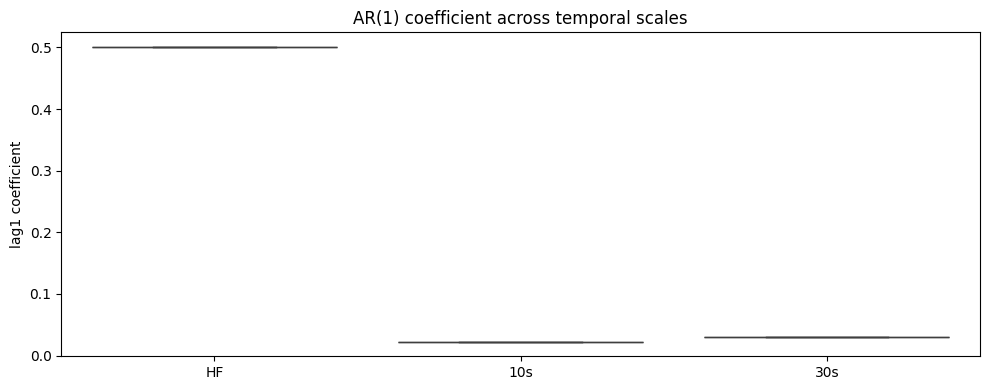

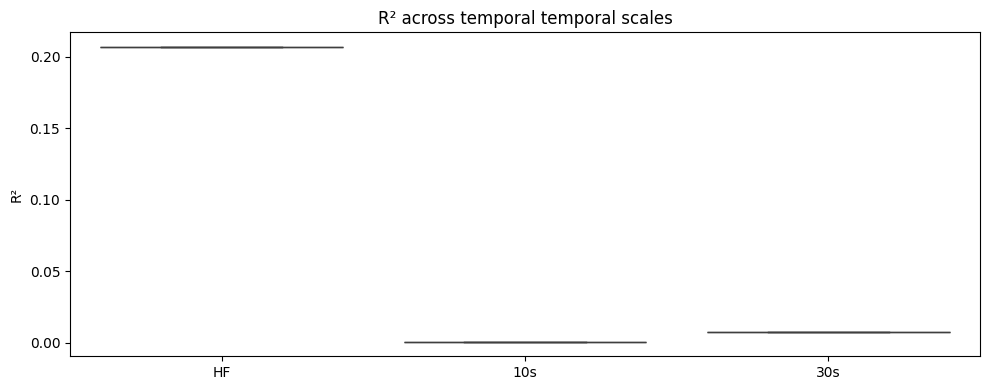

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- lag1 boxplot ---
fig, ax = plt.subplots(figsize=(10, 4))
sns.boxplot(data=df_res, x="scale", y="lag1", ax=ax)
ax.set_title("AR(1) coefficient across temporal scales")
ax.set_ylabel("lag1 coefficient")
ax.set_xlabel("")
fig.tight_layout()
fig.savefig("/home/s232713/figures/ar_boxplot_lag1.pdf", format="pdf", bbox_inches="tight")
plt.show()
plt.close(fig)

# --- R² boxplot ---
fig, ax = plt.subplots(figsize=(10, 4))
sns.boxplot(data=df_res, x="scale", y="r2", ax=ax)
ax.set_title("R² across temporal temporal scales")
ax.set_ylabel("R²")
ax.set_xlabel("")
fig.tight_layout()
# fig.savefig("/home/s232713/figures/ar_boxplot_r2.pdf", format="pdf", bbox_inches="tight")
plt.show()
plt.close(fig)



# AR + Environmental Models – Results Summary

## Participant 411

### 2s (raw resolution)
- R² ≈ 0.95
- Very strong autoregressive structure
- stress_lag1 ≈ 0.99 (dominant)
- Environmental variables not significant  
**Interpretation:** stress dynamics fully dominated by short-term physiological inertia.

### 10s
- R² ≈ 0.15
- stress_lag1 still significant
- No environmental predictors significant  
**Interpretation:** inertia persists at this scale, environment still irrelevant.

### 30s
- R² ≈ 0.20
- Weak AR structure remains
- Environmental variables not significant  
**Interpretation:** longer-lasting internal dynamics, no clear environmental sensitivity.

---

## Participant 399

### 2s
- R² ≈ 0.95
- stress_lag1 ≈ 0.99
- No environmental effects  
**Interpretation:** strong physiological smoothing at fine temporal scale.

### 10s
- R² ≈ 0.00
- No AR structure
- No environmental effects  
**Interpretation:** stress decorrelates once micro-scale inertia is removed.

### 30s
- R² ≈ 0.03
- stress_lag2 occasionally significant
- Environmental effects negligible or borderline  
**Interpretation:** stress behaves almost like noise at meso scales.

---

## Participant 436

### 2s
- R² ≈ 0.92
- Strong autoregressive structure
- NDVI positive and significant
- Noise negative and significant  
**Interpretation:** early indication of environmental sensitivity.

### 10s
- R² ≈ 0.02
- stress_lag2 significant
- NDVI strongly positive
- Roads transportation significant  
**Interpretation:** environmental effects emerge once inertia weakens.

### 30s
- R² ≈ 0.04
- stress_lag2 significant
- NDVI positive
- Roads transportation positive
- Noise borderline negative  
**Interpretation:** consistent environmental sensitivity across temporal scales.

---

## Cross-participant conclusions
- At high temporal resolution (2s), stress dynamics are universally dominated by physiological inertia.
- After temporal aggregation (10s–30s), environmental effects remain weak for most participants.
- A subset of participants shows consistent associations between stress and environmental features.
- Environmental sensitivity is heterogeneous and individual-specific, not universal.


# Rolling mean approach

In [25]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

In [26]:
stress_df = pd.read_csv('/home/s232713/data/gps_trip_stress.csv')
env_df = pd.read_csv('/home/s232713/data/foot_time_env.csv')

In [27]:
df = stress_df.copy()

# participant = 339
INDIVID = stress_df.loc[
    stress_df["participant ID"] == participant,
    "INDIVID"
].iloc[0]

df = stress_df.loc[
    stress_df["INDIVID"] == INDIVID
].copy()


df["Timestamp"] = pd.to_datetime(df["Timestamp"])

df = df.set_index("Timestamp")
df = df.sort_index()


df["stress_ma_10s"] = (
    df["stress_prob"]
    .rolling("10s", min_periods=1)
    .mean()
)

df["stress_ma_30s"] = (
    df["stress_prob"]
    .rolling("30s", min_periods=1)
    .mean()
)

display(df.head())
print(df[['stress_prob', 'stress_ma_10s', 'stress_ma_30s']].describe())

,participant ID,INDIVID,Latitude,Longitude,Accuracy,Altitude,Speed,Interval ID,Activity_concat,Milliseconds,stress_label,stress_prob,stress_binary,stress_ma_10s,stress_ma_30s
Timestamp,,,,,,,,,,,,,,,
2024-01-11 17:50:34,103,MMM16101,55.687079,12.492472,5.674,51.924757,0.150803,360335,Foot,1704995434000,1.0,1.0,1,1.0,1.0
2024-01-11 17:50:34,103,MMM16101,55.687074,12.492468,5.649,51.924757,0.143637,360335,Foot,1704995434000,1.0,1.0,1,1.0,1.0
2024-01-11 17:50:34,103,MMM16101,55.687069,12.492469,5.576,51.946852,0.144405,360335,Foot,1704995434000,1.0,1.0,1,1.0,1.0
2024-01-11 17:50:35,103,MMM16101,55.687067,12.492468,5.504,51.946852,0.155660,360335,Foot,1704995435000,1.0,1.0,1,1.0,1.0
2024-01-11 17:50:35,103,MMM16101,55.687065,12.492467,5.408,52.200998,0.198568,360335,Foot,1704995435000,1.0,1.0,1,1.0,1.0


        stress_prob  stress_ma_10s  stress_ma_30s
count  33444.000000   33444.000000   33444.000000
mean       0.949903       0.950223       0.950620
std        0.150130       0.053972       0.036766
min        0.499897       0.499966       0.499966
25%        1.000000       0.921057       0.931374
50%        1.000000       0.950000       0.953708
75%        1.000000       1.000000       0.973214
max        1.000000       1.000000       1.000000


In [28]:
print(df[['stress_prob', 'stress_ma_10s', 'stress_ma_30s']].value_counts())

stress_prob  stress_ma_10s  stress_ma_30s
1.0          1.000000       1.000000         3197
                            0.982143          100
                            0.981818           79
                            0.982456           69
                            0.981481           61
                                             ... 
             0.894737       0.953704            1
                            0.948276            1
                            0.888890            1
                            0.890001            1
                            0.900002            1
Name: count, Length: 17415, dtype: int64


In [29]:
env_cols = [
    "INDIVID",
    "t_entry",
    "t_exit",
    "grid_ndvi_mean",
    "noise_L_mean",
    "roads_transportation",
    "buildings_facilities"
]

env_sub = env_df.loc[
    env_df["INDIVID"] == INDIVID,
    env_cols
].copy()

env_sub["t_entry"] = pd.to_datetime(env_sub["t_entry"])
env_sub["t_exit"]  = pd.to_datetime(env_sub["t_exit"])

env_vars = [
    "grid_ndvi_mean",
    "noise_L_mean",
    "roads_transportation",
    "buildings_facilities"
]

def weighted_env_for_bin(bin_start, bin_end, env_df):
    overlaps = env_df[
        (env_df["t_exit"] > bin_start) &
        (env_df["t_entry"] < bin_end)
    ].copy()

    if overlaps.empty:
        return pd.Series({v: np.nan for v in env_vars})

    overlaps["overlap_start"] = overlaps["t_entry"].clip(lower=bin_start)
    overlaps["overlap_end"]   = overlaps["t_exit"].clip(upper=bin_end)

    overlaps["overlap_sec"] = (
        overlaps["overlap_end"] - overlaps["overlap_start"]
    ).dt.total_seconds()

    overlaps = overlaps[overlaps["overlap_sec"] > 0]
    if overlaps.empty:
        return pd.Series({v: np.nan for v in env_vars})

    w = overlaps["overlap_sec"].values
    w_sum = w.sum()

    return pd.Series({
        v: np.sum(overlaps[v].values * w) / w_sum
        for v in env_vars
    })



In [30]:
stress_30s = df[["stress_ma_30s"]].resample("30s").last()

bins_df = stress_30s.copy()
display(bins_df.head())
bins_df["bin_start"] = bins_df.index
bins_df["bin_end"]   = bins_df.index + pd.Timedelta(seconds=30)

env_weighted = bins_df.apply(
    lambda r: weighted_env_for_bin(r["bin_start"], r["bin_end"], env_sub),
    axis=1
)

env_weighted = pd.concat(
    [bins_df[["bin_start"]], env_weighted],
    axis=1
)
display(env_weighted.head())


,stress_ma_30s
Timestamp,
2024-01-11 17:50:30,1.000000
2024-01-11 17:51:00,0.881357
2024-01-11 17:51:30,0.931036
2024-01-11 17:52:00,0.938596
2024-01-11 17:52:30,0.962964


,bin_start,grid_ndvi_mean,noise_L_mean,roads_transportation,buildings_facilities
Timestamp,,,,,
2024-01-11 17:50:30,2024-01-11 17:50:30,-0.004993,49.765341,7.200000,1.866667
2024-01-11 17:51:00,2024-01-11 17:51:00,-0.011699,49.395874,6.000000,2.000000
2024-01-11 17:51:30,2024-01-11 17:51:30,0.000312,55.454544,28.000000,3.000000
2024-01-11 17:52:00,2024-01-11 17:52:00,0.000312,55.454544,28.000000,3.000000
2024-01-11 17:52:30,2024-01-11 17:52:30,-0.012481,55.136971,24.027027,3.000000


In [31]:
print(stress_30s['stress_ma_30s'].notna().sum())
print(len(stress_30s))

843
40755


In [32]:
print("Total bins:", len(stress_30s))
print("Hours of data:", len(stress_30s) * 30 / 3600)


Total bins: 40755
Hours of data: 339.625


In [33]:
stress_30s = stress_30s[stress_30s["stress_ma_30s"].notna()]
print("Total bins:", len(stress_30s))
print("Hours of data:", len(stress_30s) * 30 / 3600)

Total bins: 843
Hours of data: 7.025


In [34]:
df_model = stress_30s.merge(
    env_weighted,
    left_on="Timestamp",
    right_on="bin_start",
    how="left"
)

df_model = df_model.dropna().reset_index(drop=True)

print("Stress bins:", len(stress_30s))
print("After env merge:", len(df_model))



Stress bins: 843
After env merge: 647


In [35]:
y = df_model["stress_ma_30s"]

X = df_model[[
    "grid_ndvi_mean",
    "noise_L_mean",
    "roads_transportation",
    "buildings_facilities"
]]

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print('30s moving average model results:', model.summary())

30s moving average model results:                             OLS Regression Results                            
Dep. Variable:          stress_ma_30s   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.2034
Date:                Mon, 19 Jan 2026   Prob (F-statistic):              0.937
Time:                        15:02:13   Log-Likelihood:                 1223.0
No. Observations:                 647   AIC:                            -2436.
Df Residuals:                     642   BIC:                            -2414.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

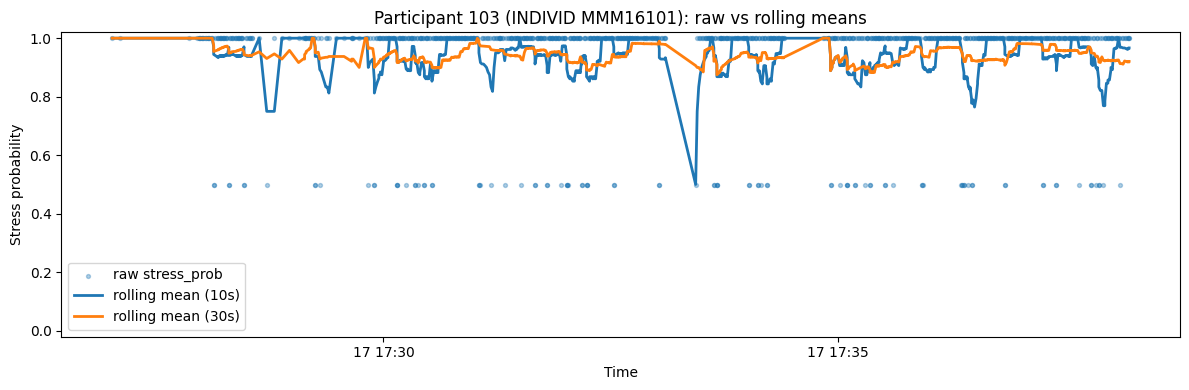

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Assumes stress_df is already loaded with columns:
# ["participant ID", "INDIVID", "Timestamp", "stress_prob"]

# participant = 339          # change if you want
segment_minutes = 20      # initial window length to grab
roll_a = "10s"
roll_b = "30s"

# trimming controls (to remove long flat tails)
eps = 1e-3                 # what counts as "non-zero"
pad_seconds = 12          # keep a bit of context before/after activity

# --- filter + prep ---
INDIVID = stress_df.loc[stress_df["participant ID"] == participant, "INDIVID"].iloc[0]

df = stress_df.loc[stress_df["INDIVID"] == INDIVID, ["Timestamp", "stress_prob"]].copy()
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df = df.sort_values("Timestamp").set_index("Timestamp")

# --- pick a segment around the middle ---
mid_ts = df.index[int(len(df) * 0.5)]
t0 = mid_ts - pd.Timedelta(minutes=segment_minutes / 2)
t1 = mid_ts + pd.Timedelta(minutes=segment_minutes / 2)
seg = df.loc[t0:t1].copy()

# rolling means
seg[f"stress_ma_{roll_a}"] = seg["stress_prob"].rolling(roll_a, min_periods=1).mean()
seg[f"stress_ma_{roll_b}"] = seg["stress_prob"].rolling(roll_b, min_periods=1).mean()

# --- trim to "interesting" part (removes long flat tails) ---
active = (
    (seg["stress_prob"].fillna(0).abs() > eps) |
    (seg[f"stress_ma_{roll_a}"].fillna(0).abs() > eps) |
    (seg[f"stress_ma_{roll_b}"].fillna(0).abs() > eps)
)

if active.any():
    first_ts = seg.index[active.argmax()]
    last_ts  = seg.index[len(active) - 1 - active.iloc[::-1].argmax()]
    first_ts = first_ts - pd.Timedelta(seconds=pad_seconds)
    last_ts  = last_ts + pd.Timedelta(seconds=pad_seconds)
    seg = seg.loc[first_ts:last_ts].copy()

# --- plot ---
plt.figure(figsize=(12, 4))

# raw as scatter so spikes don't dominate the figure
plt.scatter(
    seg.index, seg["stress_prob"],
    s=8, alpha=0.35, label="raw stress_prob"
)

plt.plot(seg.index, seg[f"stress_ma_{roll_a}"], linewidth=2, label=f"rolling mean ({roll_a})")
plt.plot(seg.index, seg[f"stress_ma_{roll_b}"], linewidth=2, label=f"rolling mean ({roll_b})")

plt.title(f"Participant {participant} (INDIVID {INDIVID}): raw vs rolling means")
plt.xlabel("Time")
plt.ylabel("Stress probability")
plt.ylim(-0.02, 1.02)
plt.legend()
plt.tight_layout()
plt.show()



-------------------

--------------------

--------------------

In [37]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

In [38]:
stress_df = pd.read_csv('/home/s232713/data/gps_trip_stress.csv')
env_df    = pd.read_csv('/home/s232713/data/foot_time_env.csv')


In [39]:
# participant = 339

INDIVID = stress_df.loc[
    stress_df["participant ID"] == participant,
    "INDIVID"
].iloc[0]

df = stress_df.loc[
    stress_df["INDIVID"] == INDIVID
].copy()


In [40]:
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df = df.set_index("Timestamp").sort_index()


In [41]:
df["stress_ma_30s"] = (
    df["stress_prob"]
    .rolling("30s", min_periods=1)
    .mean()
)

df[["stress_prob", "stress_ma_30s"]].describe()


,stress_prob,stress_ma_30s
count,33444.000000,33444.000000
mean,0.949903,0.950620
std,0.150130,0.036766
min,0.499897,0.499966
25%,1.000000,0.931374
50%,1.000000,0.953708
75%,1.000000,0.973214
max,1.000000,1.000000


In [42]:
env_cols = [
    "INDIVID",
    "t_entry",
    "t_exit",
    "grid_ndvi_mean",
    "noise_L_mean",
    "roads_transportation",
    "buildings_facilities"
]

env_sub = env_df.loc[
    env_df["INDIVID"] == INDIVID,
    env_cols
].copy()

env_sub["t_entry"] = pd.to_datetime(env_sub["t_entry"])
env_sub["t_exit"]  = pd.to_datetime(env_sub["t_exit"])


In [43]:
episodes = []

for i, row in env_sub.iterrows():
    t0 = row["t_entry"]
    t1 = row["t_exit"]

    # extract stress inside the cell
    stress_seg = df.loc[t0:t1, "stress_ma_30s"].dropna()
    if len(stress_seg) < 3:
        continue

    duration_sec = (t1 - t0).total_seconds()
    if duration_sec < 20:
        continue

    # time in seconds from episode start
    time_sec = (stress_seg.index - stress_seg.index[0]).total_seconds()

    # SAFE slope estimation
    if len(np.unique(time_sec)) > 1:
        slope = np.polyfit(time_sec, stress_seg.values, 1)[0]
    else:
        slope = np.nan

    episodes.append({
        "INDIVID": INDIVID,
        "episode_id": i,
        "duration_sec": duration_sec,
        "stress_mean": stress_seg.mean(),
        "stress_slope": slope,
        "grid_ndvi_mean": row["grid_ndvi_mean"],
        "noise_L_mean": row["noise_L_mean"],
        "roads_transportation": row["roads_transportation"],
        "buildings_facilities": row["buildings_facilities"],
    })

df_ep = pd.DataFrame(episodes)
df_ep.head()



,INDIVID,episode_id,duration_sec,stress_mean,stress_slope,grid_ndvi_mean,noise_L_mean,roads_transportation,buildings_facilities
0,MMM16101,11011,68.0,0.916068,0.002132,0.064892,52.423603,6.0,6.0
1,MMM16101,11012,65.0,0.917744,-0.001832,0.035143,53.775944,5.0,5.0
2,MMM16101,11014,56.0,0.983945,0.000805,0.010313,53.775944,4.0,3.0
3,MMM16101,11016,77.0,0.894988,-0.001154,0.028080,55.827892,6.0,1.0
4,MMM16101,11018,82.0,0.954499,0.001044,0.002226,51.428783,4.0,0.0


In [44]:
print("Episodes:", len(df_ep))
print("Slope NaN ratio:", df_ep["stress_slope"].isna().mean())
print("Total exposure hours:", df_ep["duration_sec"].sum() / 3600)


Episodes: 342
Slope NaN ratio: 0.0
Total exposure hours: 6.710277777777778


In [45]:
df_ep[[
    "stress_mean",
    "stress_slope",
    "duration_sec"
]].describe()


,stress_mean,stress_slope,duration_sec
count,342.000000,342.000000,342.000000
mean,0.951327,-0.000005,70.634503
std,0.032381,0.002000,65.433168
min,0.570299,-0.011108,20.000000
25%,0.938827,-0.000623,42.000000
50%,0.955397,-0.000126,58.000000
75%,0.967342,0.000451,72.000000
max,1.000000,0.022729,559.000000


In [46]:
env_vars = [
    "grid_ndvi_mean",
    "noise_L_mean",
    "roads_transportation",
    "buildings_facilities"
]

df_ep[env_vars] = (df_ep[env_vars] - df_ep[env_vars].mean()) / df_ep[env_vars].std()
df_ep["stress_mean_z"] = (df_ep["stress_mean"] - df_ep["stress_mean"].mean()) / df_ep["stress_mean"].std()


In [47]:
# model for mean stress
y = df_ep["stress_mean_z"]

X = df_ep[env_vars]
X = sm.add_constant(X)

w = df_ep["duration_sec"]

model = sm.WLS(y, X, weights=w).fit()
print('episode duration weighted model results:', model.summary())


episode duration weighted model results:                             WLS Regression Results                            
Dep. Variable:          stress_mean_z   R-squared:                       0.001
Model:                            WLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                   0.05787
Date:                Mon, 19 Jan 2026   Prob (F-statistic):              0.994
Time:                        15:02:15   Log-Likelihood:                -430.67
No. Observations:                 342   AIC:                             871.3
Df Residuals:                     337   BIC:                             890.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

In [48]:
# model for stress slope (does stress increase/decrease in this environment?)
# y = df_ep["stress_slope"]

# X = df_ep[env_vars]
# X = sm.add_constant(X)

# model_slope = sm.WLS(y, X, weights=w).fit()
# print(model_slope.summary())


try to see for best people data 

## Individual-level episode models: summary notes

This section reports results from weighted least squares (WLS) models fitted **separately for each participant**, using **cell-specific exposure episodes** as the unit of analysis.

### Model specification
- **Outcome**: `stress_mean_z`  
  (episode-averaged stress probability, smoothed with a 30s moving average and standardized within participant)
- **Predictors**:  
  `grid_ndvi_mean`, `noise_L_mean`, `roads_transportation`, `buildings_facilities`  
  (standardized within participant)
- **Weights**: episode duration (seconds)
- **Unit of analysis**: continuous exposure episodes within a single spatial grid cell

These individual models are used for **exploratory inspection and illustration**, not for population-level inference.

---

### Participant 436 (≈ 5 hours walking, 285 episodes)
- Clear and internally consistent associations between environment and stress.
- **Positive effects** of:
  - road exposure
  - NDVI
- **Negative effect** of:
  - noise
- Model F-test significant, with stable coefficient signs.
- Interpreted as a participant with **detectable environment–stress sensitivity**.

---

### Participant 399 (≈ 3 hours walking, 186 episodes)
- No meaningful association between environmental features and stress.
- All coefficients small and statistically non-significant.
- Model F-test not significant.
- Interpreted as a **null individual**, rather than noise-dominated or data-limited.

---

### Participant 411 (≈ 25 minutes walking, 19 episodes)
- Very small number of episodes.
- Coefficients unstable and not reliable.
- Model F-test not significant despite one isolated coefficient reaching nominal significance.
- Interpreted as **data-limited**, excluded from inferential interpretation.

---

### Interpretation across individuals
Individual-level results reveal substantial heterogeneity:
- Some participants show clear and interpretable environment–stress associations.
- Others exhibit no detectable effects.
- Very short recordings do not support reliable estimation.

For this reason, **individual models are treated as descriptive case studies**, while primary inference is conducted using **pooled episode-level models** that account for inter-individual variability.
